In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random



In [86]:
words = open('names.txt', 'r').read().splitlines()

In [87]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [88]:
block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size  # initialize with all dots
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '----->', itos[ix])
        # slide the window, by popping and appending
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [89]:
# build dataset

def build_dataset(words):
    block_size = 3  # context length: how many characters do we take to predict the next one?
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size  # initialize with all dots
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # slide the window, by popping and appending
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


In [90]:
# Setup

nhidden = 200
nembed = 10

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, nembed), generator=g)  # character embeddings
W1 = torch.randn((block_size * nembed, nhidden), generator=g)
b1 = torch.randn(nhidden, generator=g)
W2 = torch.randn((nhidden, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [91]:
sum(p.nelement() for p in parameters)

11897

In [92]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [93]:
lri = []
lossi = []
stepi = []


In [94]:

for i in range(200000):

    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, block_size * nembed) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # print(loss.item())

    for p in parameters:
        p.grad = None
    
    # Calculate gradient
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    # Parameter update
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss)
    

tensor(1.9193, grad_fn=<NllLossBackward0>)


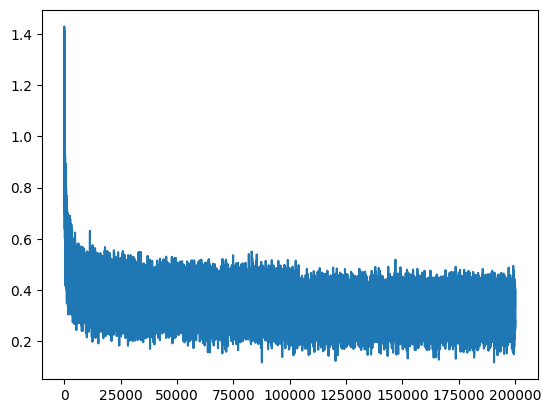

In [95]:
plt.plot(stepi, lossi)

In [96]:

emb = C[Xdev]
h = torch.tanh(emb.view(-1, block_size * nembed) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print (loss)

# plt.plot(lossi, label='Loss')
# plt.plot(lri, lossi, label='Learning rate')

tensor(2.1678, grad_fn=<NllLossBackward0>)


In [97]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_size * nembed) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print (loss)

tensor(2.1221, grad_fn=<NllLossBackward0>)


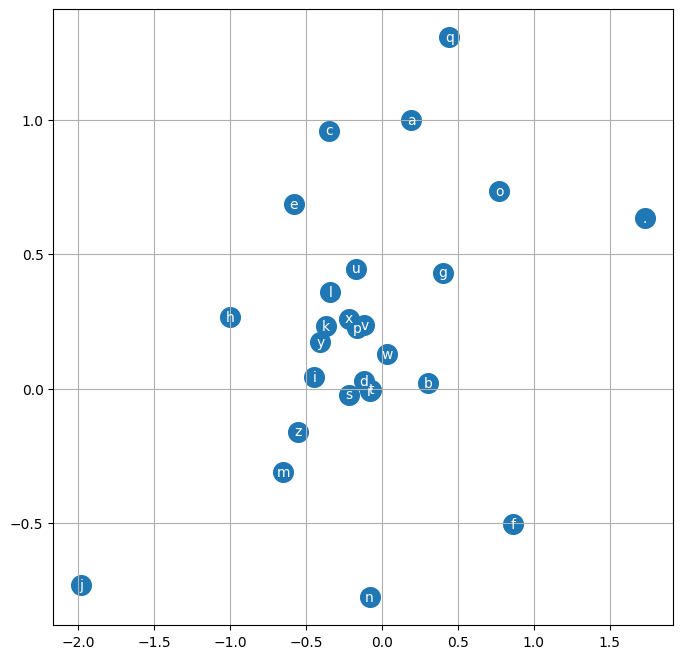

In [98]:
# Visualize character embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')


In [ ]:
context = [0] * block_size
C[torch.tensor([context])].shape


int

In [120]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahzaelyn.
vih.
jari.
reh.
caslanden.
jazhnen.
amerync.
areen.
nellara.
chaiivon.
leigh.
ham.
jorn.
quinton.
lilea.
jadique.
jerma.
jaryni.
jacen.
durathem.
